- 제시된 여행 보험 예측 데이터에서 TravelInsurance(여행보험 패키지를 구매 했는지 여부) 를 예측하는 모델을 개발하고, 모델 개발 과정과 테스트 데이터셋에 대한 auc 를 답안으로 작성하시오

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, MinMaxScaler
from scipy.special import expit,softmax
import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기

In [3]:
df = pd.read_csv("./data/travel_insurance_prediction.csv")

# 데이터 확인

In [4]:
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [5]:
df.shape

(1987, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Age                  1987 non-null   int64 
 1   Employment Type      1987 non-null   object
 2   GraduateOrNot        1987 non-null   object
 3   AnnualIncome         1987 non-null   int64 
 4   FamilyMembers        1987 non-null   int64 
 5   ChronicDiseases      1987 non-null   int64 
 6   FrequentFlyer        1987 non-null   object
 7   EverTravelledAbroad  1987 non-null   object
 8   TravelInsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 139.8+ KB


In [15]:
# 결측치 확인
df.isnull().sum()

Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

- 결측치 없음

In [7]:
df.dtypes

Age                     int64
Employment Type        object
GraduateOrNot          object
AnnualIncome            int64
FamilyMembers           int64
ChronicDiseases         int64
FrequentFlyer          object
EverTravelledAbroad    object
TravelInsurance         int64
dtype: object

In [8]:
df.describe()

,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000
mean,29.650226,9.327630e+05,4.752894,0.277806,0.357323
std,2.913308,3.768557e+05,1.609650,0.448030,0.479332
min,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,35.000000,1.800000e+06,9.000000,1.000000,1.000000


## object type 확인

In [9]:
df["Employment Type"].value_counts()

Employment Type
Private Sector/Self Employed    1417
Government Sector                570
Name: count, dtype: int64

In [10]:
df["GraduateOrNot"].value_counts()

GraduateOrNot
Yes    1692
No      295
Name: count, dtype: int64

- 여행보험 패키지에 졸업여부가 필요하다고 생각 되지 않음

In [11]:
df["FrequentFlyer"].value_counts()

FrequentFlyer
No     1570
Yes     417
Name: count, dtype: int64

- Frequent Flyer : 상용고객 우대제도는 많은 항공사에서 자주 이용하는 손님을 위해 제공하는 서비스들이다. 보통 항공사의 고객은 포인트를 모으는 회원제에 가입하고, 비행기를 탄 거리에 따른 포인트를 적립

In [12]:
df["EverTravelledAbroad"].value_counts()

EverTravelledAbroad
No     1607
Yes     380
Name: count, dtype: int64

## 새로운 컬럼 지정

In [17]:
# 졸업여부 제외 새로운 컬럼 생성
df_new = df.drop("GraduateOrNot", axis = 1)

In [18]:
df_new.head()

,Age,Employment Type,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,700000,8,1,Yes,No,0


# 데이터 전처리

### LableEncoder를 사용하여 범주형 데이터를 숫자로 변환

In [33]:
cols = df_new.select_dtypes(include="object").columns

In [34]:
le = LabelEncoder()

In [35]:
for col in cols:
    df_new[col] = le.fit_transform(df_new[col])

In [36]:
df_new.head()

,Age,Employment Type,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,0,400000,6,1,0,0,0
1,31,1,1250000,7,0,0,0,0
2,34,1,500000,4,1,0,0,1
3,28,1,700000,3,1,0,0,0
4,28,1,700000,8,1,1,0,0


- Employment Type : 0 = "Government Sector", 1 = "Private Sector/Self Employed"
- FrequentFlyer : 0 = "No", 1 = "Yes"
- EverTravelledAbroad : 0 = "No", 1 = "Yes"

## 데이터 상관계수 확인

In [37]:
df_corr = df_new.corr()
df_corr

,Age,Employment Type,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
Age,1.000000,-0.115134,-0.020101,0.027409,0.007359,-0.033159,-0.012779,0.061060
Employment Type,-0.115134,1.000000,0.349157,-0.003354,-0.011553,0.143790,0.181098,0.147847
AnnualIncome,-0.020101,0.349157,1.000000,-0.015367,-0.001149,0.353087,0.486043,0.396763
FamilyMembers,0.027409,-0.003354,-0.015367,1.000000,0.028209,-0.023775,-0.020755,0.079909
ChronicDiseases,0.007359,-0.011553,-0.001149,0.028209,1.000000,-0.043720,0.021238,0.018190
FrequentFlyer,-0.033159,0.143790,0.353087,-0.023775,-0.043720,1.000000,0.277334,0.232103
EverTravelledAbroad,-0.012779,0.181098,0.486043,-0.020755,0.021238,0.277334,1.000000,0.433183
TravelInsurance,0.061060,0.147847,0.396763,0.079909,0.018190,0.232103,0.433183,1.000000


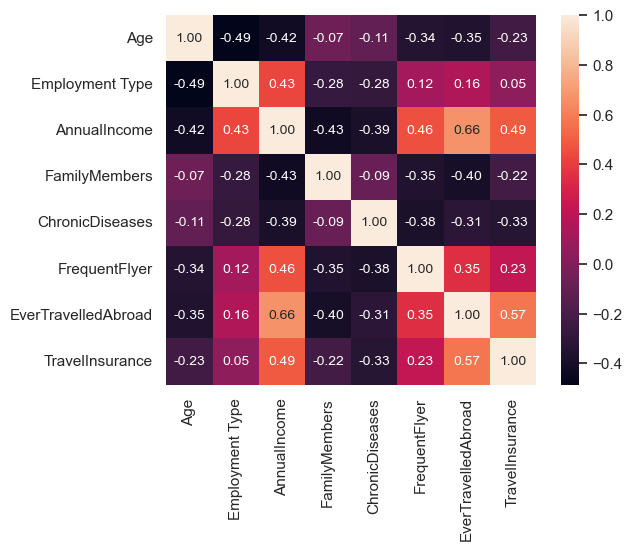

In [38]:
# 상관계수 시각화
corr_mat = np.corrcoef(df_corr.values.T)
sns.set()
full_mat = sns.heatmap(corr_mat, cbar = True, annot = True, square = True, fmt = ".2f",
                      annot_kws = {"size" : 10}, yticklabels = df_corr,
                      xticklabels = df_corr)
plt.show()

- "Age", "FamilyMembers", "ChronicDiseases"가 "TravelInsurance" 여부와 가장 상관계수가 낮은 것을 확인

In [41]:
x = df_new.drop("TravelInsurance", axis = 1)
y = df_new["TravelInsurance"]

In [42]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.25, stratify = y, 
                                                 random_state = 4)

In [43]:
print(x_train.shape, x_test.shape)

(1490, 7) (497, 7)


In [58]:
print(y_train.shape, y_test.shape)

(1490,) (497,)


In [60]:
ss = StandardScaler()
ss_scaled_train = ss.fit_transform(x_train)
ss_scaled_test = ss.transform(x_test)

In [61]:
mm = MinMaxScaler()
mm_scaled_train = mm.fit_transform(x_train)
mm_scaled_test = mm.transform(x_test)

In [62]:
ru = RobustScaler()
ru_scaled_train = ru.fit_transform(x_train)
ru_scaled_test = ru.transform(x_test)

# 모델 훈련 및 평가

##  의사결정나무

### 모델 훈련

In [76]:
dt_ss = DecisionTreeClassifier(random_state = 4)
dt_ss.fit(ss_scaled_train, y_train)

DecisionTreeClassifier(random_state=4)

In [77]:
dt_mm = DecisionTreeClassifier(random_state = 4)
dt_mm.fit(mm_scaled_train, y_train)

DecisionTreeClassifier(random_state=4)

In [78]:
dt_ru = DecisionTreeClassifier(random_state = 4)
dt_ru.fit(ru_scaled_train, y_train)

DecisionTreeClassifier(random_state=4)

In [87]:
dt_ss_pred = dt_ss.predict_proba(ss_scaled_test)

In [88]:
dt_mm_pred = dt_mm.predict_proba(mm_scaled_test)

In [89]:
dt_ru_pred = dt_ru.predict_proba(ru_scaled_test)

### 평가

In [102]:
print('Standard :', roc_auc_score(y_test, dt_ss_pred[:,1]))

Standard : 0.7605931457151914


In [103]:
print('MinMax :', roc_auc_score(y_test, dt_mm_pred[:,1]))

MinMax : 0.7559261737874681


In [105]:
print('Robuster :', roc_auc_score(y_test, dt_ru_pred[:,1]))

Robuster : 0.7601088373075974


## 랜덤포레스트

### 모델 훈련

In [82]:
rf_ss = RandomForestClassifier(n_jobs = -1, random_state = 4)
rf_ss.fit(ss_scaled_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=4)

In [83]:
rf_mm = RandomForestClassifier(n_jobs = -1, random_state = 4)
rf_mm.fit(mm_scaled_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=4)

In [84]:
rf_ru = RandomForestClassifier(n_jobs = -1, random_state = 4)
rf_ru.fit(ru_scaled_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=4)

In [93]:
rf_ss_pred = rf_ss.predict_proba(ss_scaled_test)
rf_mm_pred = rf_mm.predict_proba(mm_scaled_test)
rf_ru_pred = rf_ru.predict_proba(ru_scaled_test)

### 평가

In [95]:
print('Standard :', roc_auc_score(y_test, rf_ss_pred[:,1]))
print('MinMax :', roc_auc_score(y_test, rf_mm_pred[:,1]))
print('Robuster :', roc_auc_score(y_test, rf_ru_pred[:,1]))

Standard : 0.8066288612588496
MinMax : 0.8092089042302137
Robuster : 0.8074125603184107


## 그레디언트 부스팅

### 모델 훈련

In [96]:
gb_ss = GradientBoostingClassifier(random_state = 4)
gb_ss.fit(ss_scaled_train, y_train)

GradientBoostingClassifier(random_state=4)

In [97]:
gb_mm = GradientBoostingClassifier(random_state = 4)
gb_mm.fit(mm_scaled_train, y_train)

GradientBoostingClassifier(random_state=4)

In [98]:
gb_ru = GradientBoostingClassifier(random_state = 4)
gb_ru.fit(ru_scaled_train, y_train)

GradientBoostingClassifier(random_state=4)

In [100]:
gb_ss_pred = gb_ss.predict_proba(ss_scaled_test)
gb_mm_pred = gb_mm.predict_proba(mm_scaled_test)
gb_ru_pred = gb_ru.predict_proba(ru_scaled_test)

### 평가

In [101]:
print('Standard :', roc_auc_score(y_test, gb_ss_pred[:,1]))
print('MinMax :', roc_auc_score(y_test, gb_mm_pred[:,1]))
print('Robuster :', roc_auc_score(y_test, gb_ru_pred[:,1]))

Standard : 0.830025360149343
MinMax : 0.830025360149343
Robuster : 0.8297788031418407


## 로지스틱회귀

### 모델 훈련

In [106]:
lr_ss = LogisticRegression()
lr_ss.fit(ss_scaled_train, y_train)

LogisticRegression()

In [107]:
lr_mm = LogisticRegression()
lr_mm.fit(mm_scaled_train, y_train)

LogisticRegression()

In [108]:
lr_ru = LogisticRegression()
lr_ru.fit(ru_scaled_train, y_train)

LogisticRegression()

In [109]:
lr_ss_pred = lr_ss.predict_proba(ss_scaled_test)
lr_mm_pred = lr_mm.predict_proba(mm_scaled_test)
lr_ru_pred = lr_ru.predict_proba(ru_scaled_test)

### 평가

In [110]:
print('Standard :', roc_auc_score(y_test, lr_ss_pred[:,1]))
print('MinMax :', roc_auc_score(y_test, lr_mm_pred[:,1]))
print('Robuster :', roc_auc_score(y_test, lr_ru_pred[:,1]))

Standard : 0.8138142369060618
MinMax : 0.8135148462540946
Robuster : 0.8133739565355218


## 엑스트라트리

### 모델 훈련

In [111]:
et_ss = ExtraTreesClassifier(n_jobs = -1, random_state = 4)
et_ss.fit(ss_scaled_train, y_train)

ExtraTreesClassifier(n_jobs=-1, random_state=4)

In [112]:
et_mm = ExtraTreesClassifier(n_jobs = -1, random_state = 4)
et_mm.fit(mm_scaled_train, y_train)

ExtraTreesClassifier(n_jobs=-1, random_state=4)

In [113]:
et_ru = ExtraTreesClassifier(n_jobs = -1, random_state = 4)
et_ru.fit(ru_scaled_train, y_train)

ExtraTreesClassifier(n_jobs=-1, random_state=4)

In [114]:
et_ss_pred = et_ss.predict_proba(ss_scaled_test)
et_mm_pred = et_mm.predict_proba(mm_scaled_test)
et_ru_pred = et_ru.predict_proba(ru_scaled_test)

### 평가

In [115]:
print('Standard :', roc_auc_score(y_test, et_ss_pred[:,1]))
print('MinMax :', roc_auc_score(y_test, et_mm_pred[:,1]))
print('Robuster :', roc_auc_score(y_test, et_ru_pred[:,1]))

Standard : 0.7690905568666127
MinMax : 0.7691081680814342
Robuster : 0.769116973688845


## 정리

- 의사결정나무, 랜덤포레스트, 그레디언트부스팅, 로지스틱회귀, 엑스트라트리 모델 중 그레디언트부스팅 모델의 평가가 가장 높았음
- 그레디언트부스팅 > 로지스틱회귀 > 랜덤포레스트 > 엑스트라트리 > 의사결정나무 순으로 모델의 성능을 확인할 수 있었음